# Classificação em Séries Temporais

In [1]:
import json
import pandas as pd
import seaborn as sns
from scipy.stats import norm as normal_dist
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import community

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [2]:
SHORT_TERM = 25
LONG_TERM = 125

In [3]:
bvsp = pd.read_csv('./BVSP.csv')
bvsp['day'] = pd.to_datetime(bvsp.date, dayfirst=True)
bvsp = bvsp.drop(['date'], axis=1)
bvsp = bvsp.set_index('day')
bvsp = bvsp[~bvsp.close.isna()]

# Tratar apenas dados pós Plano Real
bvsp = bvsp[bvsp.index > '1994-04-01'].sort_index()
bvsp.head()

,close
day,
1994-04-04,1355.000000
1994-04-05,1428.000000
1994-04-06,1435.500000
1994-04-07,1474.900024
1994-04-08,1537.400024


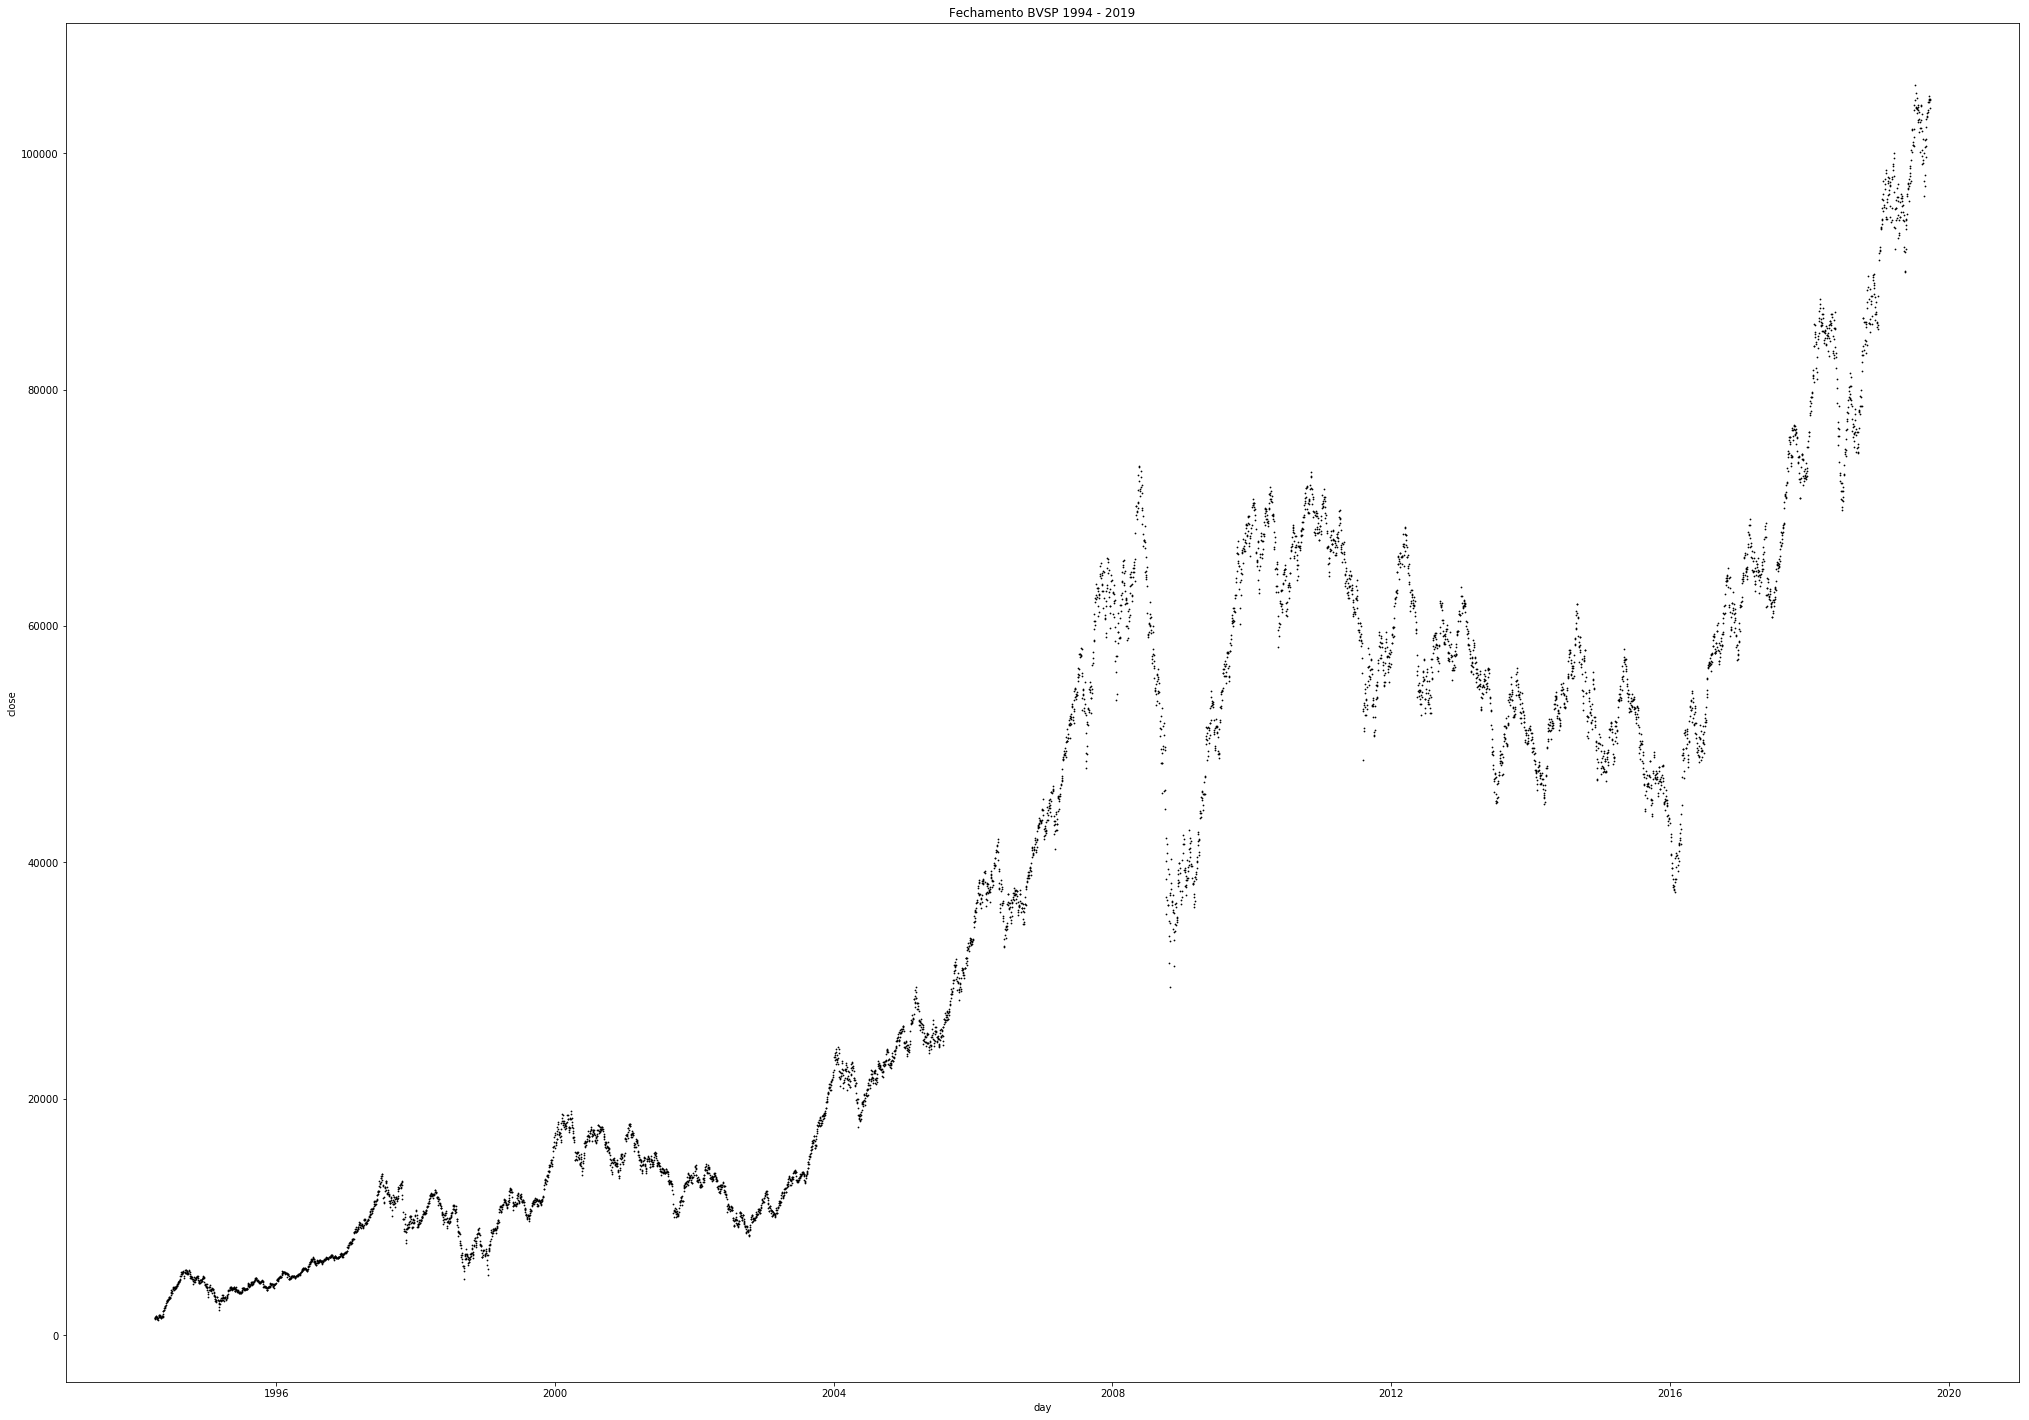

In [4]:
plt.figure(figsize=(35, 25))
sns.scatterplot(bvsp.index, bvsp.close, s=1, markers=['o'], color='black', edgecolor=None)
plt.title("Fechamento BVSP 1994 - 2019")
plt.savefig('plots/plain_all.png')

## Calculando Features

In [43]:
bvsp = bvsp.assign(
    short_min = bvsp.rolling(SHORT_TERM).close.min(),
    short_max = bvsp.rolling(SHORT_TERM).close.max(),
    short_mean = bvsp.rolling(SHORT_TERM).close.mean(),
    
    long_min = bvsp.rolling(LONG_TERM).close.min(),
    long_max = bvsp.rolling(LONG_TERM).close.max(),
    long_mean = bvsp.rolling(LONG_TERM).close.mean()
)
bvsp = bvsp.assign(
    short_noise = (bvsp.close - bvsp.short_mean) / bvsp.short_mean,
    long_noise = (bvsp.close - bvsp.long_mean) / bvsp.long_mean,
)
bvsp = bvsp.assign(
    prev_short_mean = bvsp.short_mean.shift(),
    prev_long_mean = bvsp.long_mean.shift()
)
bvsp = bvsp.assign(
    short_gradient = (bvsp.short_mean - bvsp.prev_short_mean) / bvsp.prev_short_mean,
    long_gradient = (bvsp.long_mean - bvsp.prev_long_mean) / bvsp.prev_long_mean
)

bvsp = bvsp.assign(
    short_rel = (bvsp.close - bvsp.short_min) / (bvsp.short_max - bvsp.short_min),
    long_rel = (bvsp.close - bvsp.long_min) / (bvsp.long_max - bvsp.long_min)
)

In [6]:
df = bvsp[['short_noise', 'long_noise', 'short_gradient', 'long_gradient', 'short_rel', 'long_rel']][LONG_TERM + SHORT_TERM:]
df

,short_noise,long_noise,short_gradient,long_gradient,short_rel,long_rel
day,,,,,,
1994-11-09,0.016280,0.179333,-0.004960,0.006487,0.545812,0.842115
1994-11-10,0.041635,0.197339,-0.002850,0.006656,0.788163,0.868706
1994-11-11,0.035020,0.180099,-0.001793,0.006359,0.883575,0.858424
1994-11-14,0.034596,0.171800,-0.000257,0.006411,0.878779,0.857588
1994-11-16,0.042163,0.173864,0.000944,0.006492,0.938227,0.865013
...,...,...,...,...,...,...
2019-09-19,0.030073,0.055465,0.002090,0.000859,0.966044,0.906598
2019-09-20,0.032748,0.059344,0.001979,0.000903,1.000000,0.936805
2019-09-23,0.028888,0.056738,0.002037,0.000754,0.978657,0.925493


## Normalizando dados

Normalização pelo z-score

In [7]:
def F_norm(f):
    std_norm = (f - f.mean()) / f.std()
    return normal_dist.cdf(std_norm, loc=0, scale=1)

df_norm = df.apply(F_norm, axis=0)
df_norm

,short_noise,long_noise,short_gradient,long_gradient,short_rel,long_rel
day,,,,,,
1994-11-09,0.569750,0.874862,0.083813,0.999639,0.461420,0.759909
1994-11-10,0.739707,0.902032,0.198499,0.999747,0.719982,0.785354
1994-11-11,0.698708,0.876116,0.280926,0.999532,0.802438,0.775706
1994-11-14,0.695983,0.862063,0.423893,0.999579,0.798679,0.774911
1994-11-16,0.742853,0.865656,0.544329,0.999643,0.842220,0.781917
...,...,...,...,...,...,...
2019-09-19,0.666264,0.564462,0.655721,0.576466,0.860292,0.818763
2019-09-20,0.683984,0.576604,0.645307,0.586171,0.880374,0.842919
2019-09-23,0.658297,0.568453,0.650778,0.553176,0.868004,0.834133


Discretização das colunas

In [8]:
def _discretize(x, reach, bins):
        for bi in bins[:-1]:
            if x < bi + reach: return bi
        
        return bins[-1]
    
def discretize(f, step, min=0, max=1):
    reach = step / 2
    bins = np.arange(min, max + step, step)
    return f.apply(lambda x: _discretize(x, reach, bins))

df_disc = df_norm.apply(lambda col: discretize(col, 0.25))
df_disc

,short_noise,long_noise,short_gradient,long_gradient,short_rel,long_rel
day,,,,,,
1994-11-09,0.50,0.75,0.00,1.0,0.50,0.75
1994-11-10,0.75,1.00,0.25,1.0,0.75,0.75
1994-11-11,0.75,1.00,0.25,1.0,0.75,0.75
1994-11-14,0.75,0.75,0.50,1.0,0.75,0.75
1994-11-16,0.75,0.75,0.50,1.0,0.75,0.75
...,...,...,...,...,...,...
2019-09-19,0.75,0.50,0.75,0.5,0.75,0.75
2019-09-20,0.75,0.50,0.75,0.5,1.00,0.75
2019-09-23,0.75,0.50,0.75,0.5,0.75,0.75


/home/rainsong/.local/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


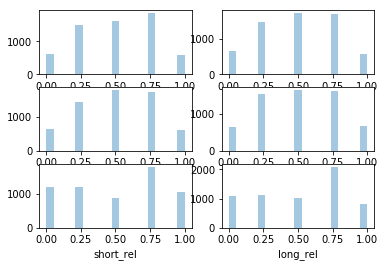

In [9]:
fig, axs = plt.subplots(nrows=3, ncols=2)
sns.distplot(df_disc.short_noise, ax=axs[0][0], kde=False)
sns.distplot(df_disc.long_noise, ax=axs[0][1], kde=False)
sns.distplot(df_disc.short_gradient, ax=axs[1][0], kde=False)
sns.distplot(df_disc.long_gradient, ax=axs[1][1], kde=False)
sns.distplot(df_disc.short_rel, ax=axs[2][0], kde=False)
sns.distplot(df_disc.long_rel, ax=axs[2][1], kde=False)

## Montagem do Grafo

Pegando nós únicos e gerando ids para eles

In [10]:
model_nodes = df_disc.drop_duplicates()
model_nodes = model_nodes.assign(
    node_id= range(1, len(model_nodes) + 1)
).set_index('node_id')
model_nodes

,short_noise,long_noise,short_gradient,long_gradient,short_rel,long_rel
node_id,,,,,,
1,0.50,0.75,0.00,1.00,0.50,0.75
2,0.75,1.00,0.25,1.00,0.75,0.75
3,0.75,0.75,0.50,1.00,0.75,0.75
4,0.50,0.75,0.25,1.00,0.75,0.75
5,0.25,0.75,0.25,1.00,0.50,0.75
...,...,...,...,...,...,...
784,0.75,0.25,1.00,0.25,0.75,0.50
785,0.75,0.25,1.00,0.25,1.00,0.50
786,1.00,0.50,0.75,0.25,1.00,0.75


Atribuindo linhas de _df_disc_ para seus nós

In [11]:
df_with_ids = df_disc.merge(model_nodes.reset_index(),
                    on='short_noise long_noise short_gradient long_gradient short_rel long_rel'.split(),
                    right_index=True).sort_index()[['node_id']]
df_with_ids.head(5)

,node_id
day,
1994-11-09,1
1994-11-10,2
1994-11-11,2
1994-11-14,3
1994-11-16,3


In [12]:
# state_graph = pd.DataFrame(columns)
edges = df_with_ids[:-1].assign(
    source = df_with_ids[:-1].node_id,
    target = df_with_ids.shift(-1).dropna().astype(int)
)

edges = edges[['source', 'target']]

# remove self loops
edges = edges[edges.source != edges.target]

edges

,source,target
day,,
1994-11-09,1,2
1994-11-11,2,3
1994-11-16,3,4
1994-11-17,4,5
1994-11-18,5,6
...,...,...
2019-09-18,655,219
2019-09-19,219,607
2019-09-20,607,219


In [13]:
nx_graph = nx.convert_matrix.from_pandas_edgelist(edges, source='source', target='target')

### Visualização do grafo


In [14]:
with open('edges.js', 'w') as f:
    f.write('document.edges = ')
    f.write(edges.to_json(orient='records'))

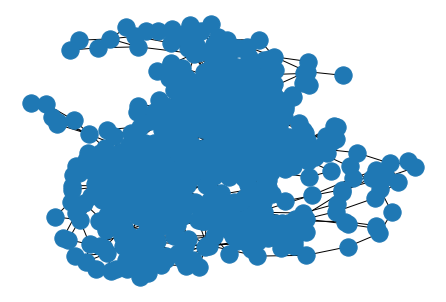

In [15]:
nx.draw(nx_graph)
plt.show()

![](./images/graph_2.png)


## Detecção de comunidades

In [16]:
partition = community.best_partition(nx_graph)

comms = set(partition.values())
size = len(comms)
print(f'Detected {size} communities')

Detected 12 communities


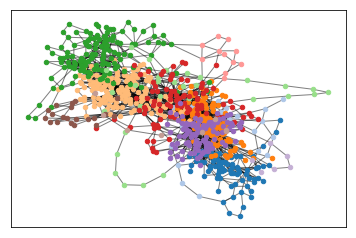

In [17]:
pos = nx.spring_layout(nx_graph)
count = 0

colormap = plt.cm.tab20(range(0, size))
for com in set(partition.values()) :
    list_nodes = [nodes for nodes in partition.keys()
                                if partition[nodes] == com]
    nx.draw_networkx_nodes( nx_graph, pos, list_nodes, node_size = 20,
                            node_color = [colormap[count]])
    count = count + 1
    
nx.draw_networkx_edges(nx_graph, pos, alpha=0.5)
plt.show()

In [18]:
with open('partitions.js', 'w') as f:
    f.write('document.partitions = ' + json.dumps(partition))

In [19]:
node_ids, partition_ids = zip(*partition.items())
partition_df = pd.DataFrame({
    'node_id': node_ids,
    'partition': partition_ids
})
partition_df = partition_df.set_index('node_id')[['partition']]
partition_df

,partition
node_id,
1,0
2,0
3,0
4,0
5,0
...,...
784,6
785,6
786,6


In [20]:
bvsp_with_partitions = df_with_ids\
                        .merge(partition_df, left_on='node_id', right_index=True)\
                        .merge(bvsp, left_index=True, right_index=True, how='inner')

bvsp_with_partitions = bvsp_with_partitions[['close', 'node_id', 'partition']]\
    .sort_index()

bvsp_with_partitions

,close,node_id,partition
day,,,
1994-11-09,4885.000000,1,0
1994-11-10,4992.600098,2,0
1994-11-11,4952.000000,2,0
1994-11-14,4948.700195,3,0
1994-11-16,4989.600098,3,0
...,...,...,...
2019-09-19,104339.000000,219,8
2019-09-20,104817.000000,607,8
2019-09-23,104638.000000,219,8


### Série histórica com partições

#### Dataset inteiro

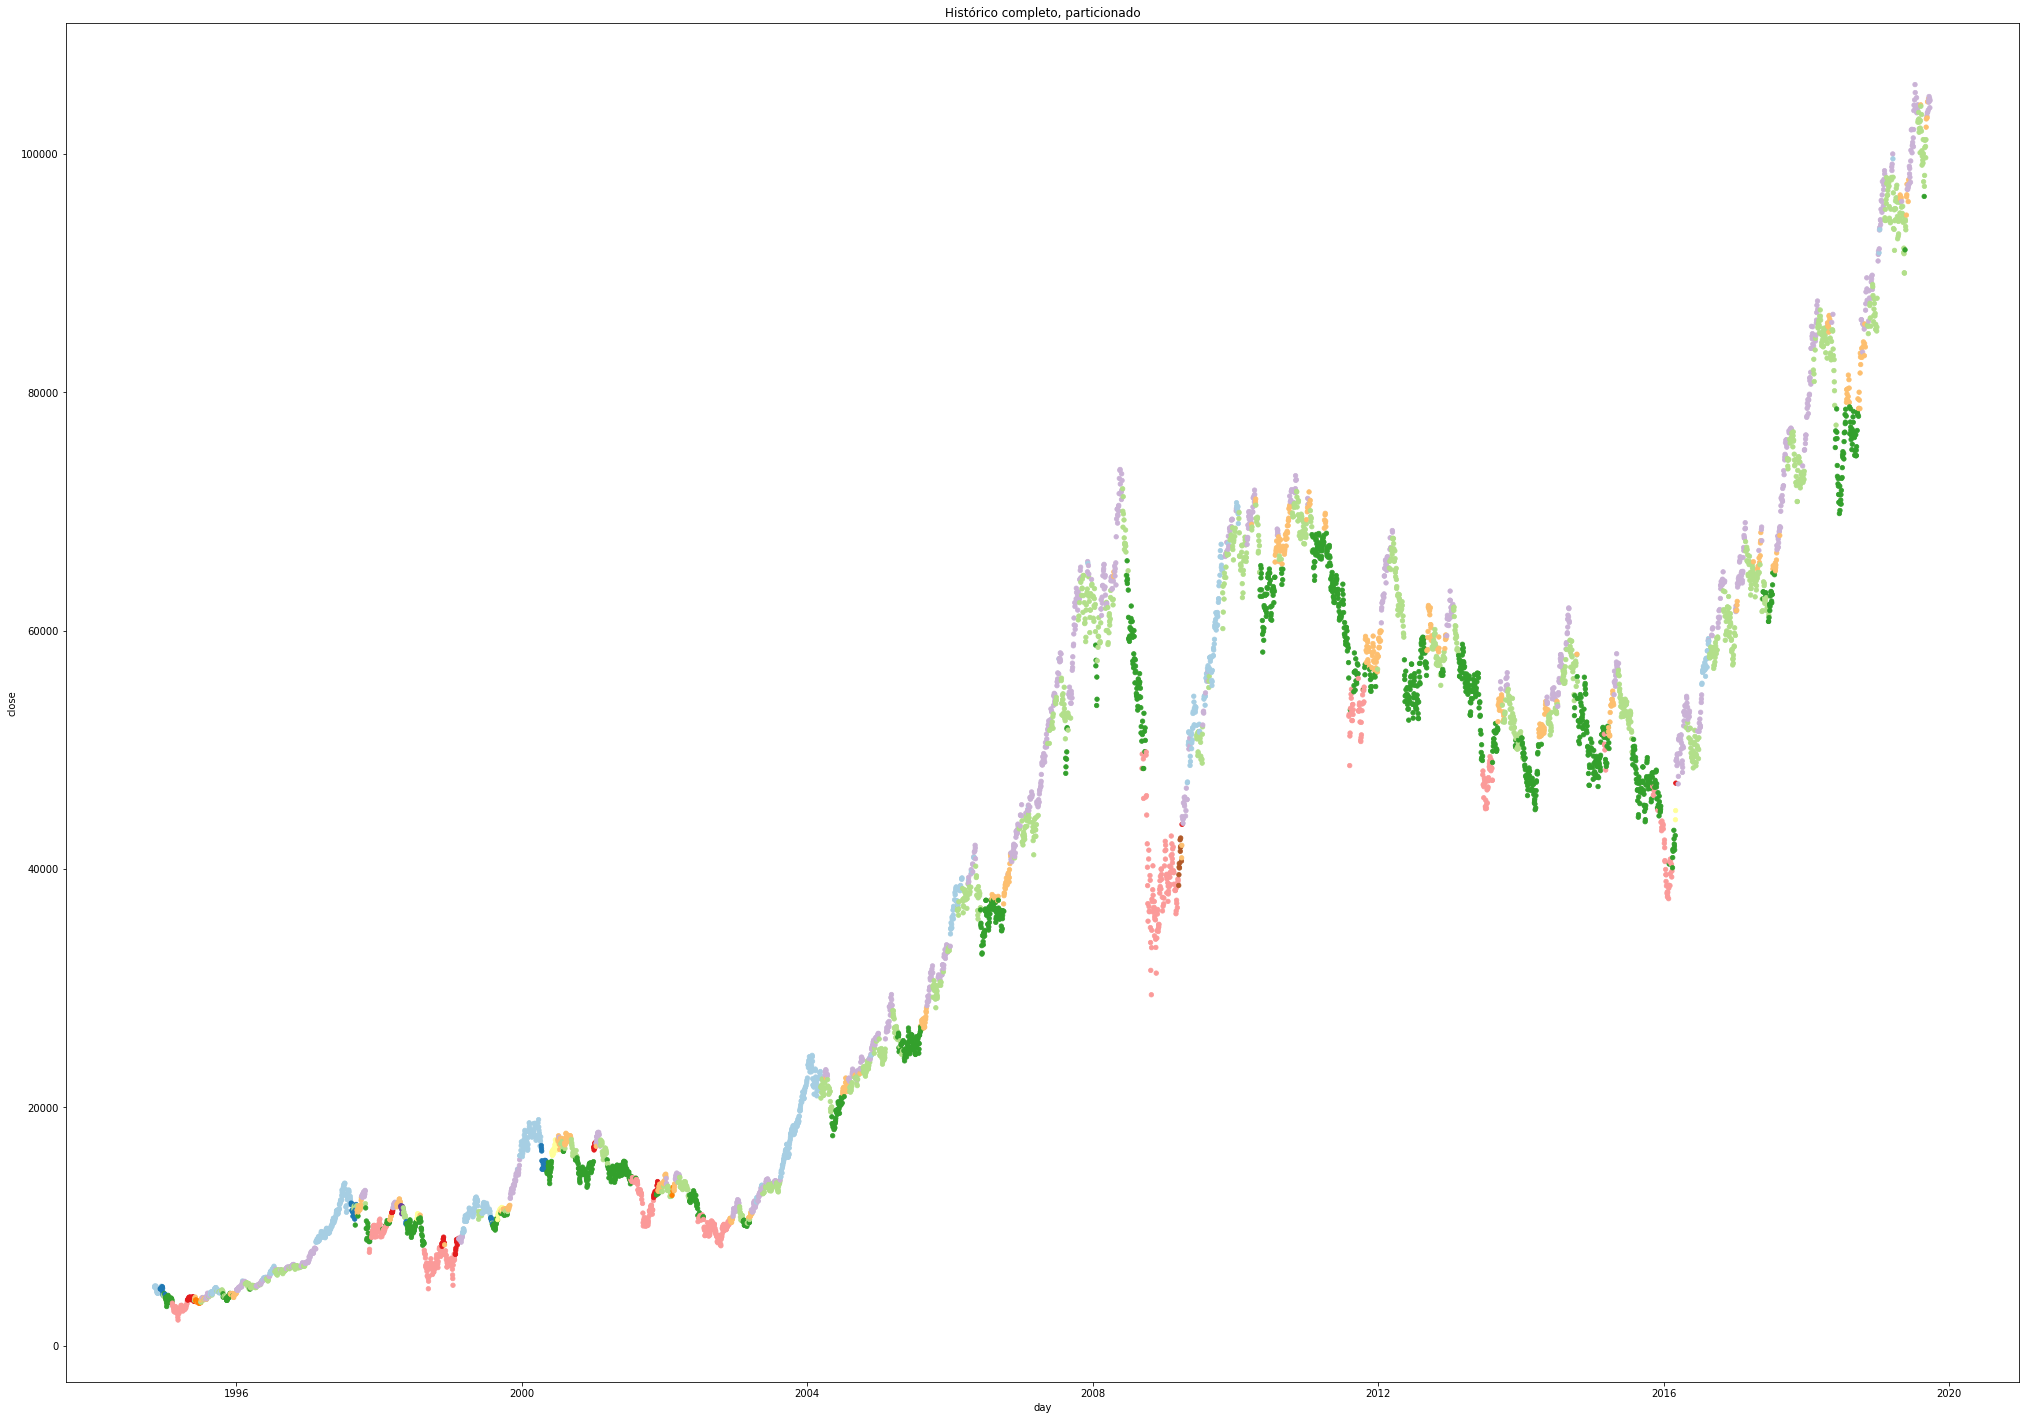

In [21]:
palette=sns.color_palette('Paired', n_colors=bvsp_with_partitions.partition.unique().size)
plt.figure(figsize=(35, 25))
ax = plt.subplot()
sns.scatterplot(x='day', y='close', data=bvsp_with_partitions.reset_index(),
                hue='partition', palette=palette,
                s=20, markers=['o'], edgecolor=None, legend=False)
plt.title('Histórico completo, particionado')

plt.savefig('plots/partitions_all.png')

#### Últimos 730 dias

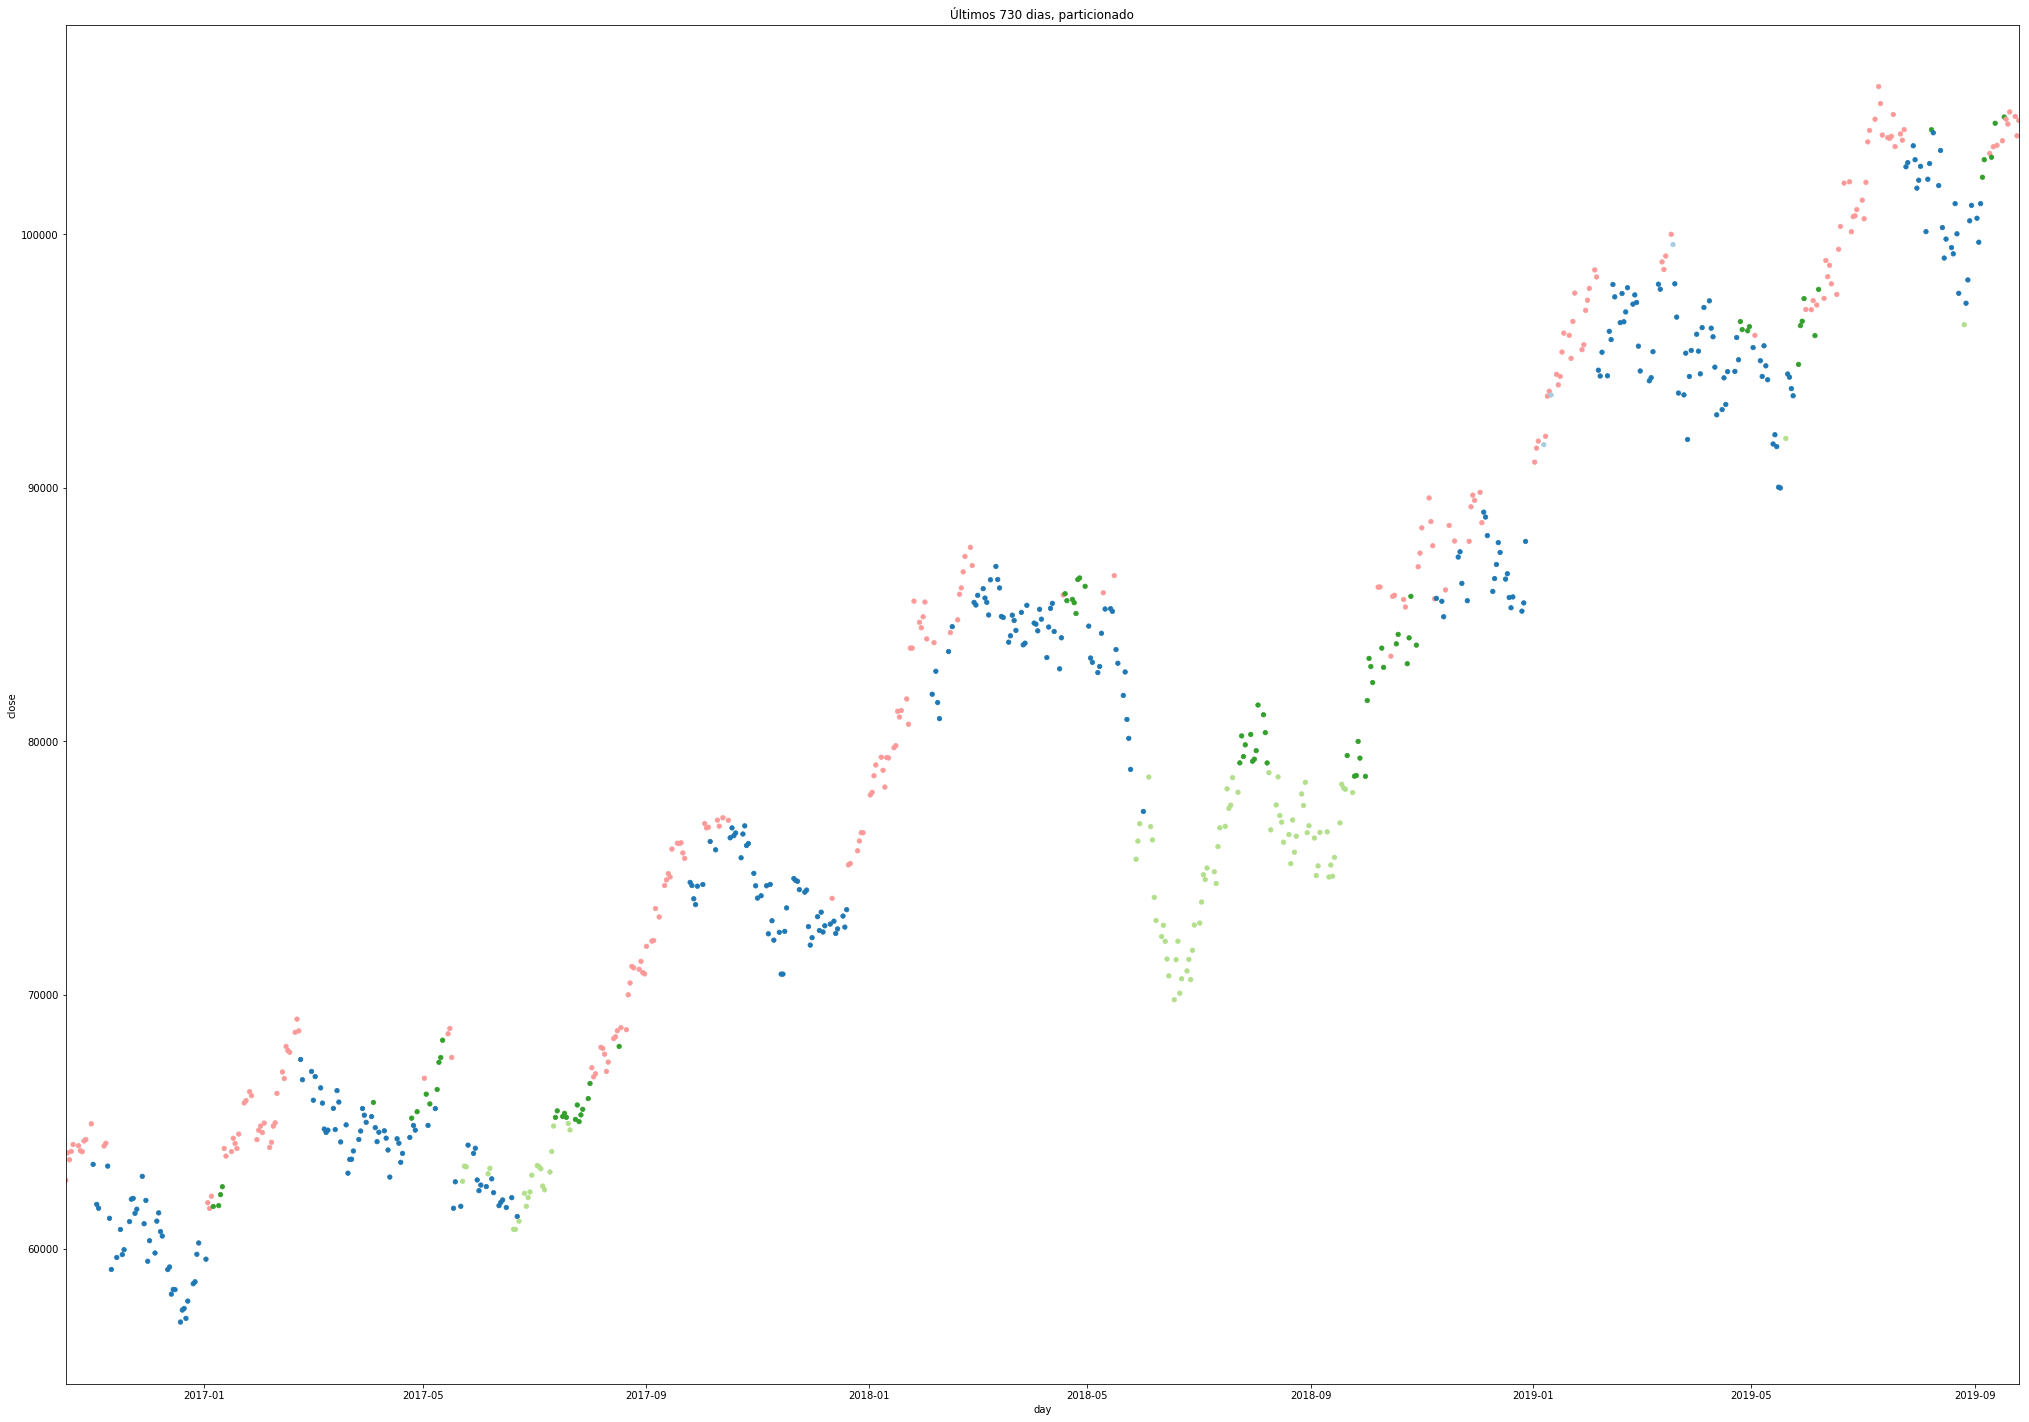

In [22]:
t = bvsp_with_partitions.iloc[-730:].reset_index()
palette=sns.color_palette('Paired', n_colors=t.partition.unique().size)
plt.figure(figsize=(35, 25))
ax = plt.subplot()
sns.scatterplot(x='day', y='close', data=t,
                hue='partition', palette=palette,
                s=20, markers=['o'], edgecolor=None, legend=False)
plt.title('Últimos 730 dias, particionado')
ax.set_xlim(t.day.min(), t.day.max())
plt.savefig('plots/partitions_720.png')

In [23]:
partition_labels = pd.DataFrame({
    'partition': bvsp_with_partitions.partition,
    'delta_score': bvsp_with_partitions.close.rolling(2).apply(lambda x: (x[1] / x[0]))
})[1:]


partition_labels = partition_labels.groupby('partition').agg({
    'delta_score': 'mean'
})

# partition_labels = bvsp_with_partitions\
#     .groupby(['partition', 'ocurrence_label']).agg(
#         delta_score=('close', get_delta_score)
#     )\
#     .dropna()\
#     .groupby(['partition']).agg(
#         delta_score = ('delta_score', 'mean'),
#     )
partition_labels

/home/rainsong/miniconda3/envs/compsys/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
  This is separate from the ipykernel package so we can avoid doing imports until


,delta_score
partition,
0,1.003387
1,0.992876
2,0.997415
3,0.999177
4,0.998647
5,1.007849
6,1.003706
7,0.999720
8,1.004575


### Quantis do delta score

In [24]:
for i in np.arange(0, 1, 0.05):
    print('q', "%.2f" % round(i,2), ':' ,partition_labels.delta_score.quantile(i))

q 0.00 : 0.9928764801955586
q 0.05 : 0.9939504461709885
q 0.10 : 0.9950876911967046
q 0.15 : 0.9965096919487083
q 0.20 : 0.9976611514218321
q 0.25 : 0.9983391636569157
q 0.30 : 0.9988061638452592
q 0.35 : 0.9990973206613192
q 0.40 : 0.9993940177866709
q 0.45 : 0.9996927925280072
q 0.50 : 1.0015536068556612
q 0.55 : 1.0034032120717145
q 0.60 : 1.003578686585444
q 0.65 : 1.003755519614844
q 0.70 : 1.0039359753526989
q 0.75 : 1.0041695667142352
q 0.80 : 1.0044669208241896
q 0.85 : 1.0052818587001466
q 0.90 : 1.0063925587281053
q 0.95 : 1.0071592027042942


### Discretização / Criação das labels

In [25]:

partition_labels['partition_label'] = 'unknown'
d = 0.0001
partition_labels.loc[partition_labels['delta_score'] > 1. + d, 'partition_label'] = 'up'
partition_labels.loc[partition_labels['delta_score'] < 1. - d, 'partition_label'] = 'down'
partition_labels

,delta_score,partition_label
partition,,
0,1.003387,up
1,0.992876,down
2,0.997415,down
3,0.999177,down
4,0.998647,down
5,1.007849,up
6,1.003706,up
7,0.999720,down
8,1.004575,up


In [26]:
partition_labels.partition_label.value_counts()

up      6
down    6
Name: partition_label, dtype: int64

In [27]:
bvsp_labeled = bvsp_with_partitions.reset_index().merge(partition_labels, on='partition', left_index=True)
bvsp_labeled = bvsp_labeled['day close delta_score partition_label'.split()].set_index('day').sort_index()
bvsp_labeled

,close,delta_score,partition_label
day,,,
1994-11-09,4885.000000,1.003387,up
1994-11-10,4992.600098,1.003387,up
1994-11-11,4952.000000,1.003387,up
1994-11-14,4948.700195,1.003387,up
1994-11-16,4989.600098,1.003387,up
...,...,...,...
2019-09-19,104339.000000,1.004575,up
2019-09-20,104817.000000,1.004575,up
2019-09-23,104638.000000,1.004575,up


In [28]:
bvsp_labeled.partition_label.value_counts()

down    3613
up      2545
Name: partition_label, dtype: int64

#### Plot completo pré discretização de label

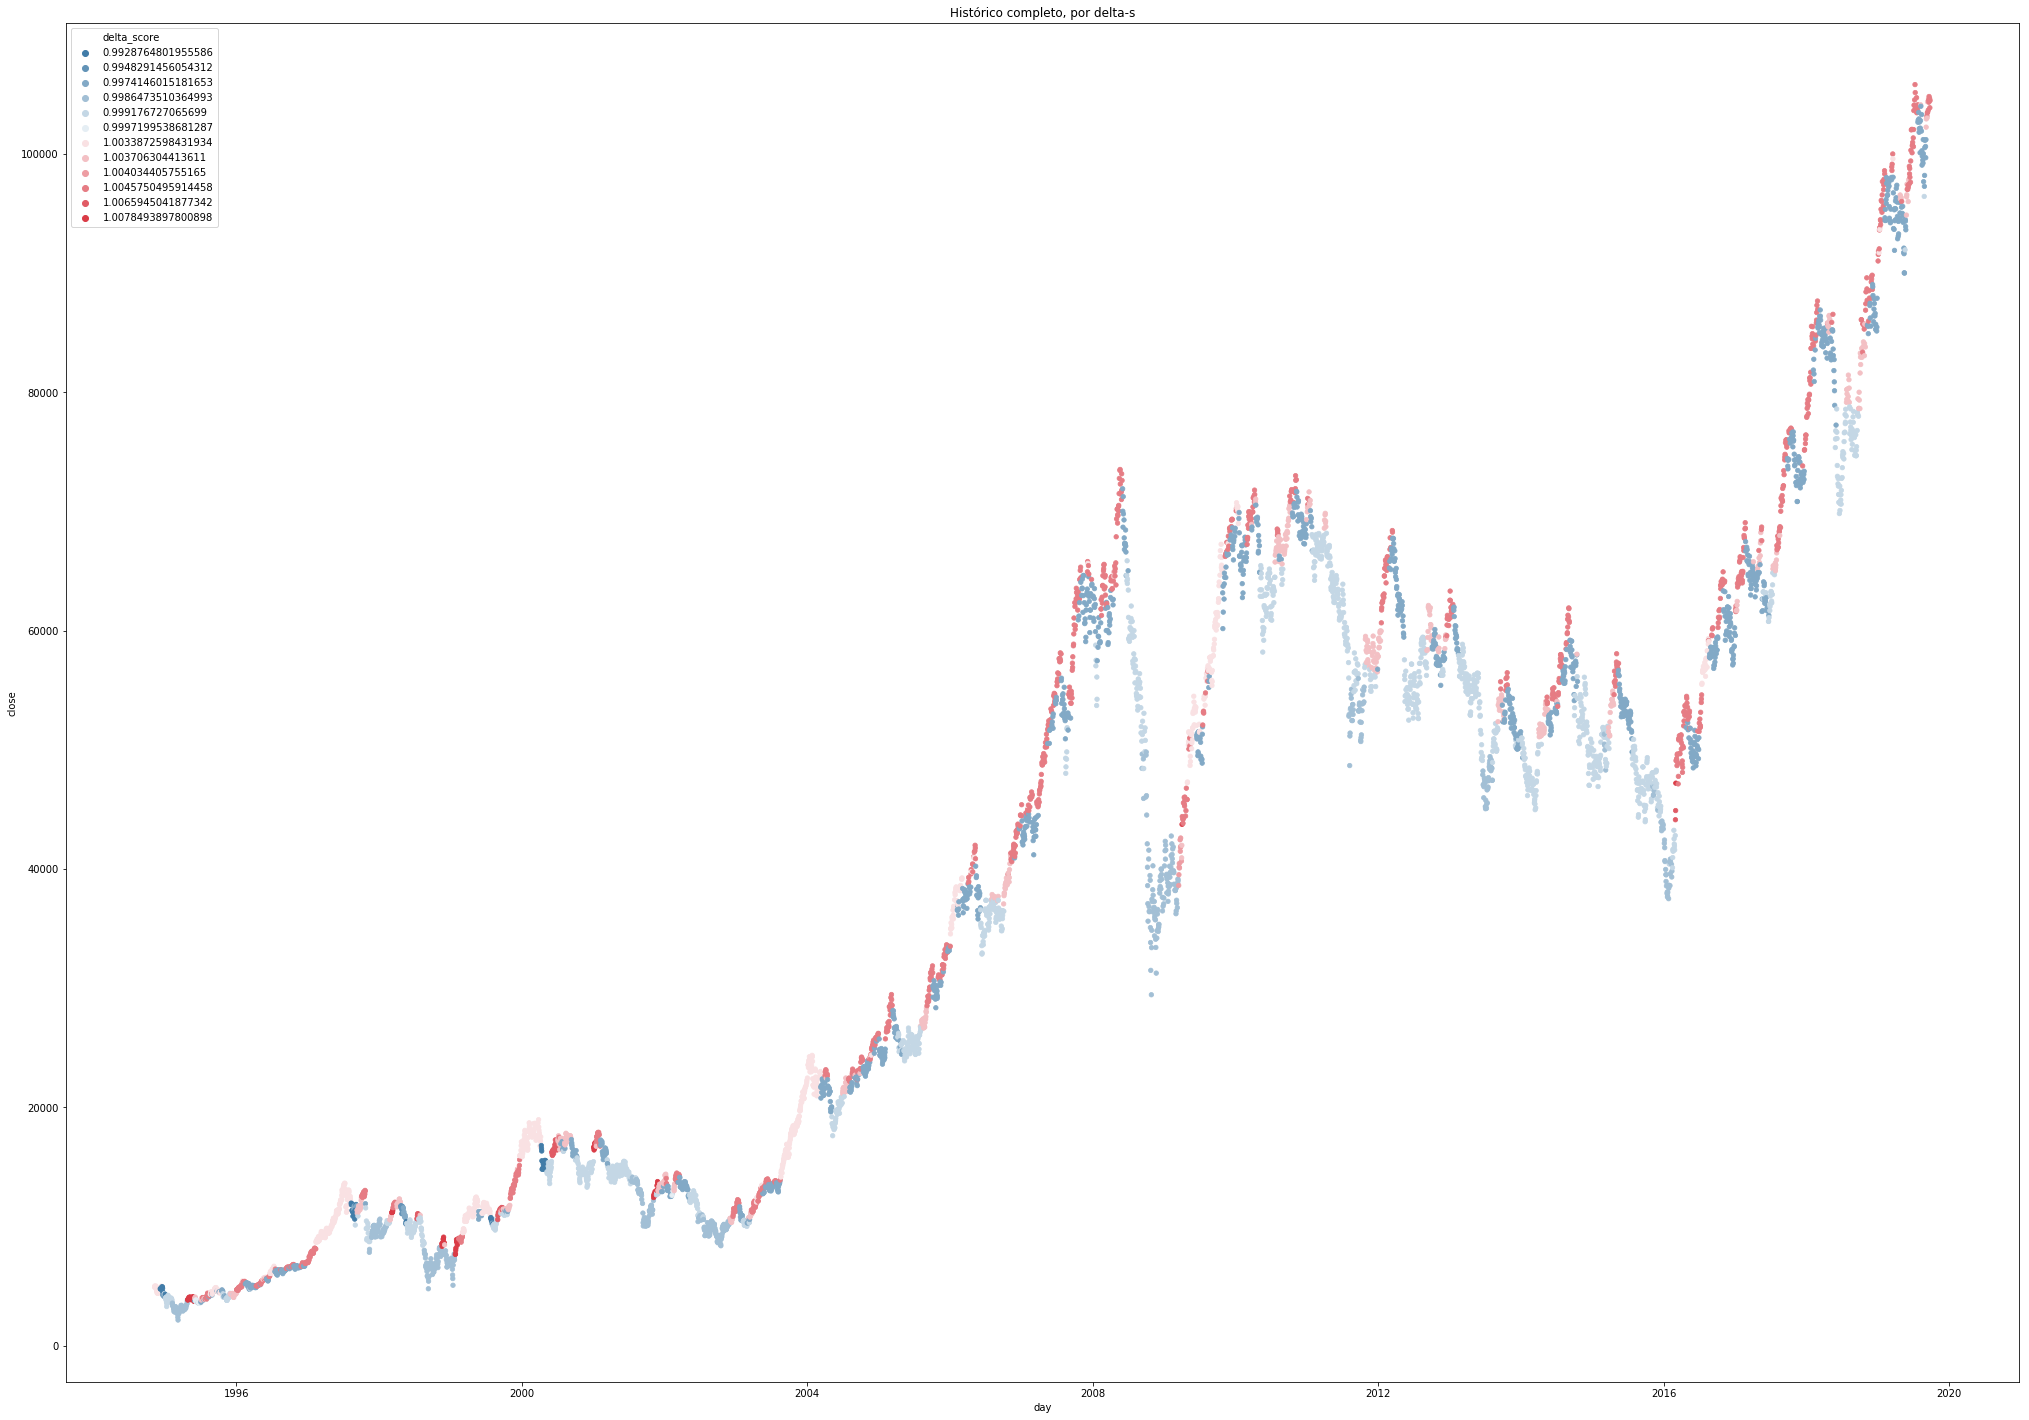

In [29]:
t = bvsp_labeled
#palette= sns.color_palette('Blues', n_colors=t.delta_score.unique().size)
palette = sns.diverging_palette(240, 10, n=t.delta_score.unique().size)
plt.figure(figsize=(35, 25))
sns.scatterplot(x='day', y='close', data=t.reset_index(),
                hue='delta_score', palette=palette,
                s=20, markers=['o'], edgecolor=None, legend='full')

plt.title('Histórico completo, por delta-s')
plt.savefig('plots/delta_score_all.png')

#### Plot completo pós discretização de label

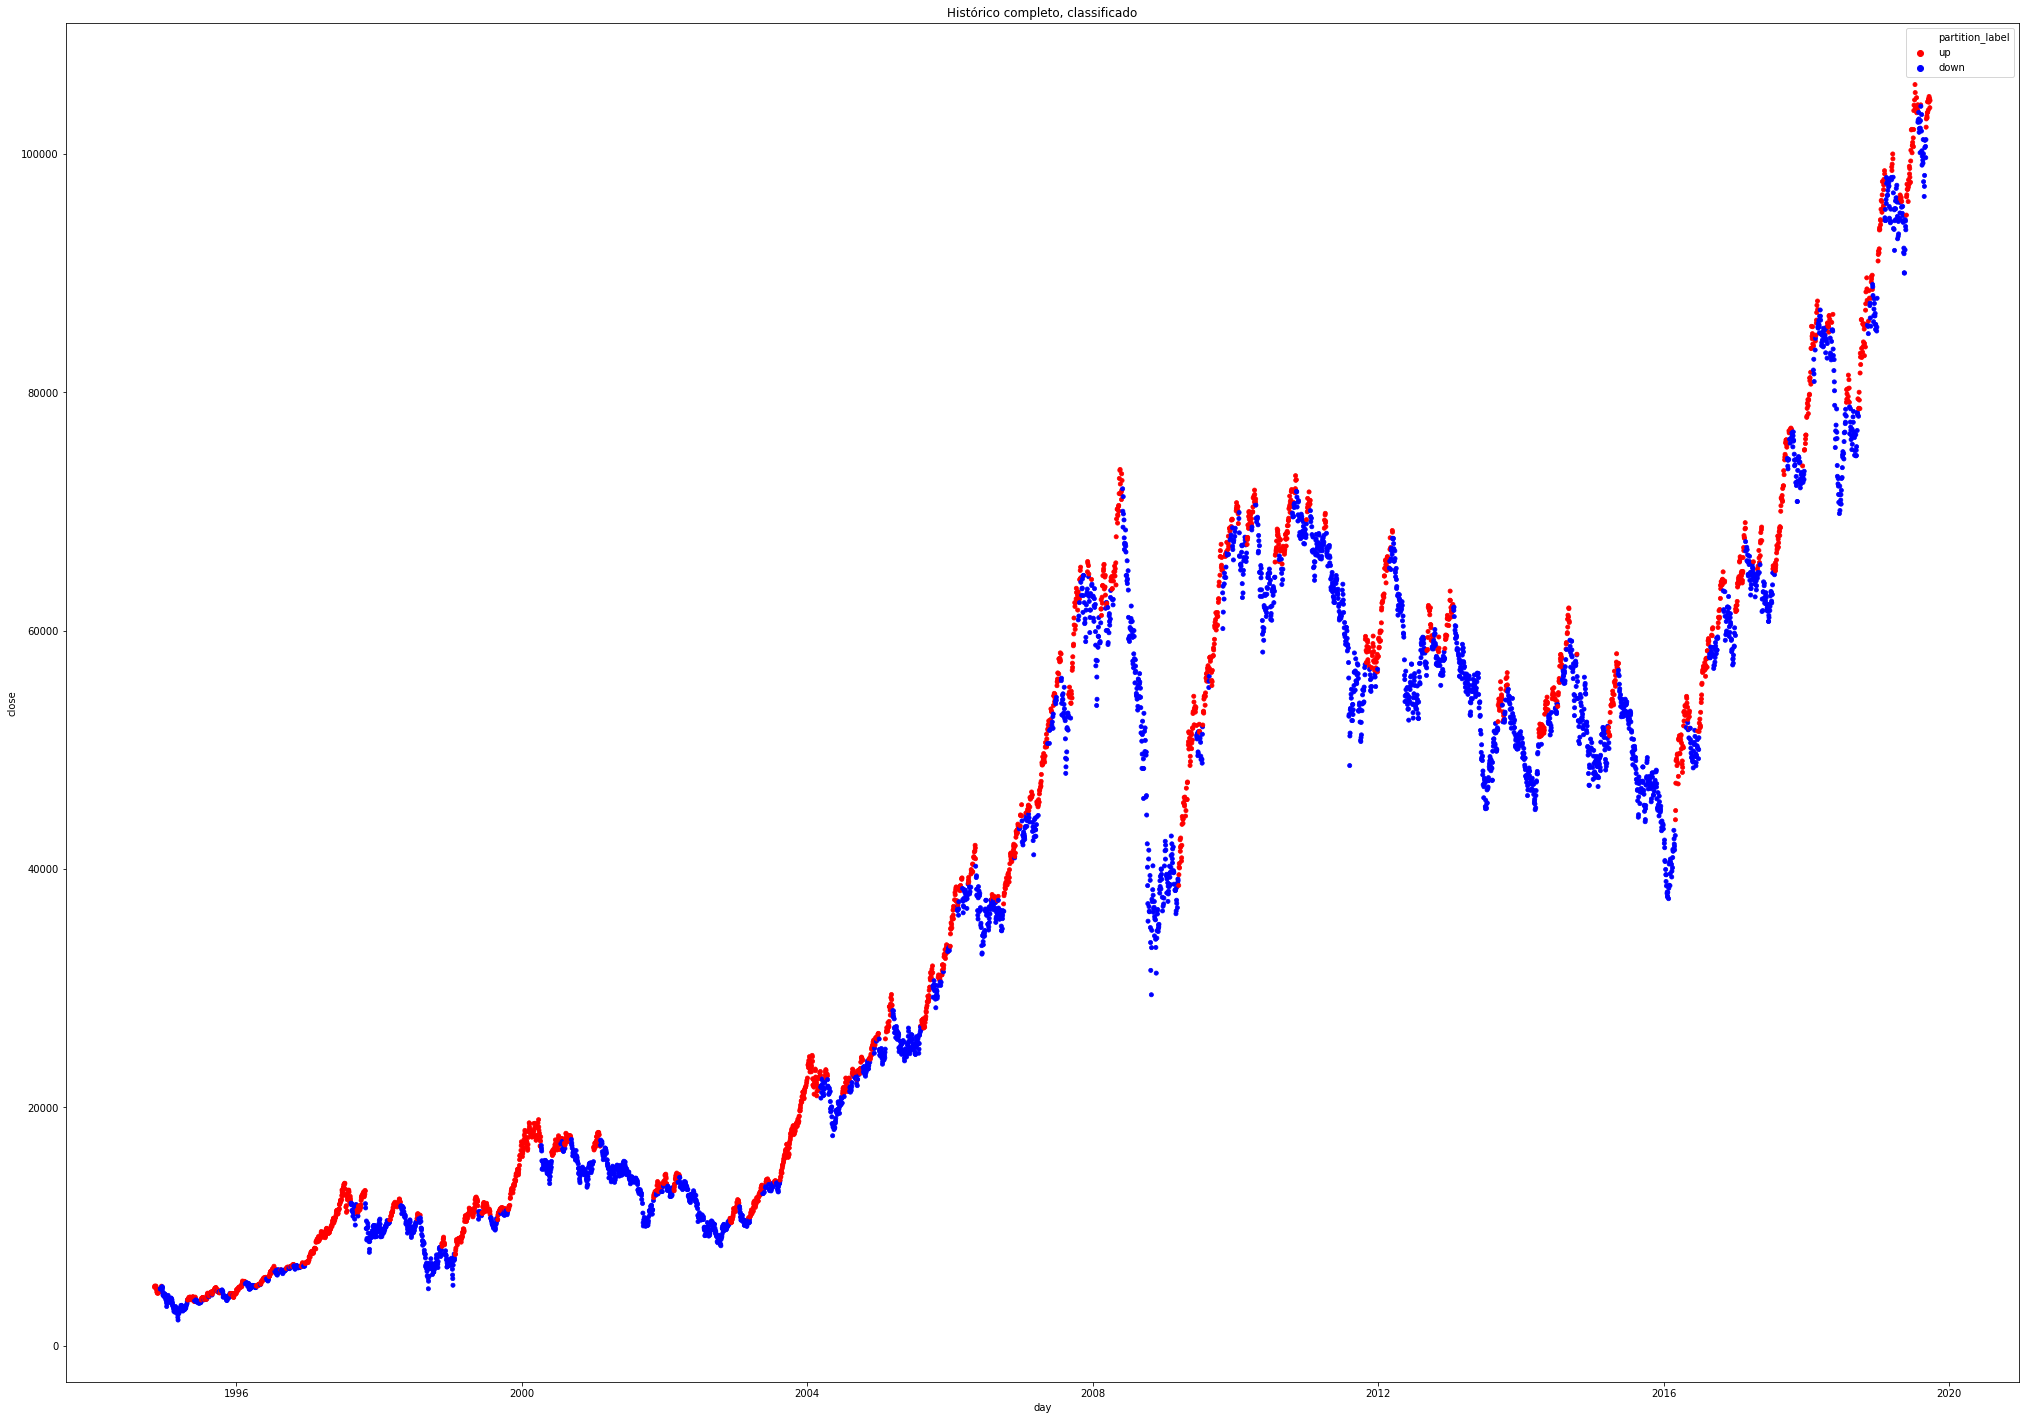

In [30]:
t = bvsp_labeled#.sample(frac=1)
palette={
    'up': 'red',
    'down': 'blue',
    'unknown': 'gray'
}
plt.figure(figsize=(35, 25))
sns.scatterplot(x='day', y='close', data=t.reset_index(),
                hue='partition_label', palette=palette,
                s=17, markers=['o'], edgecolor=None, legend='full')

plt.title('Histórico completo, classificado')
plt.savefig('plots/classified_all.png')

#### Plot 720 dias pré discretização de label

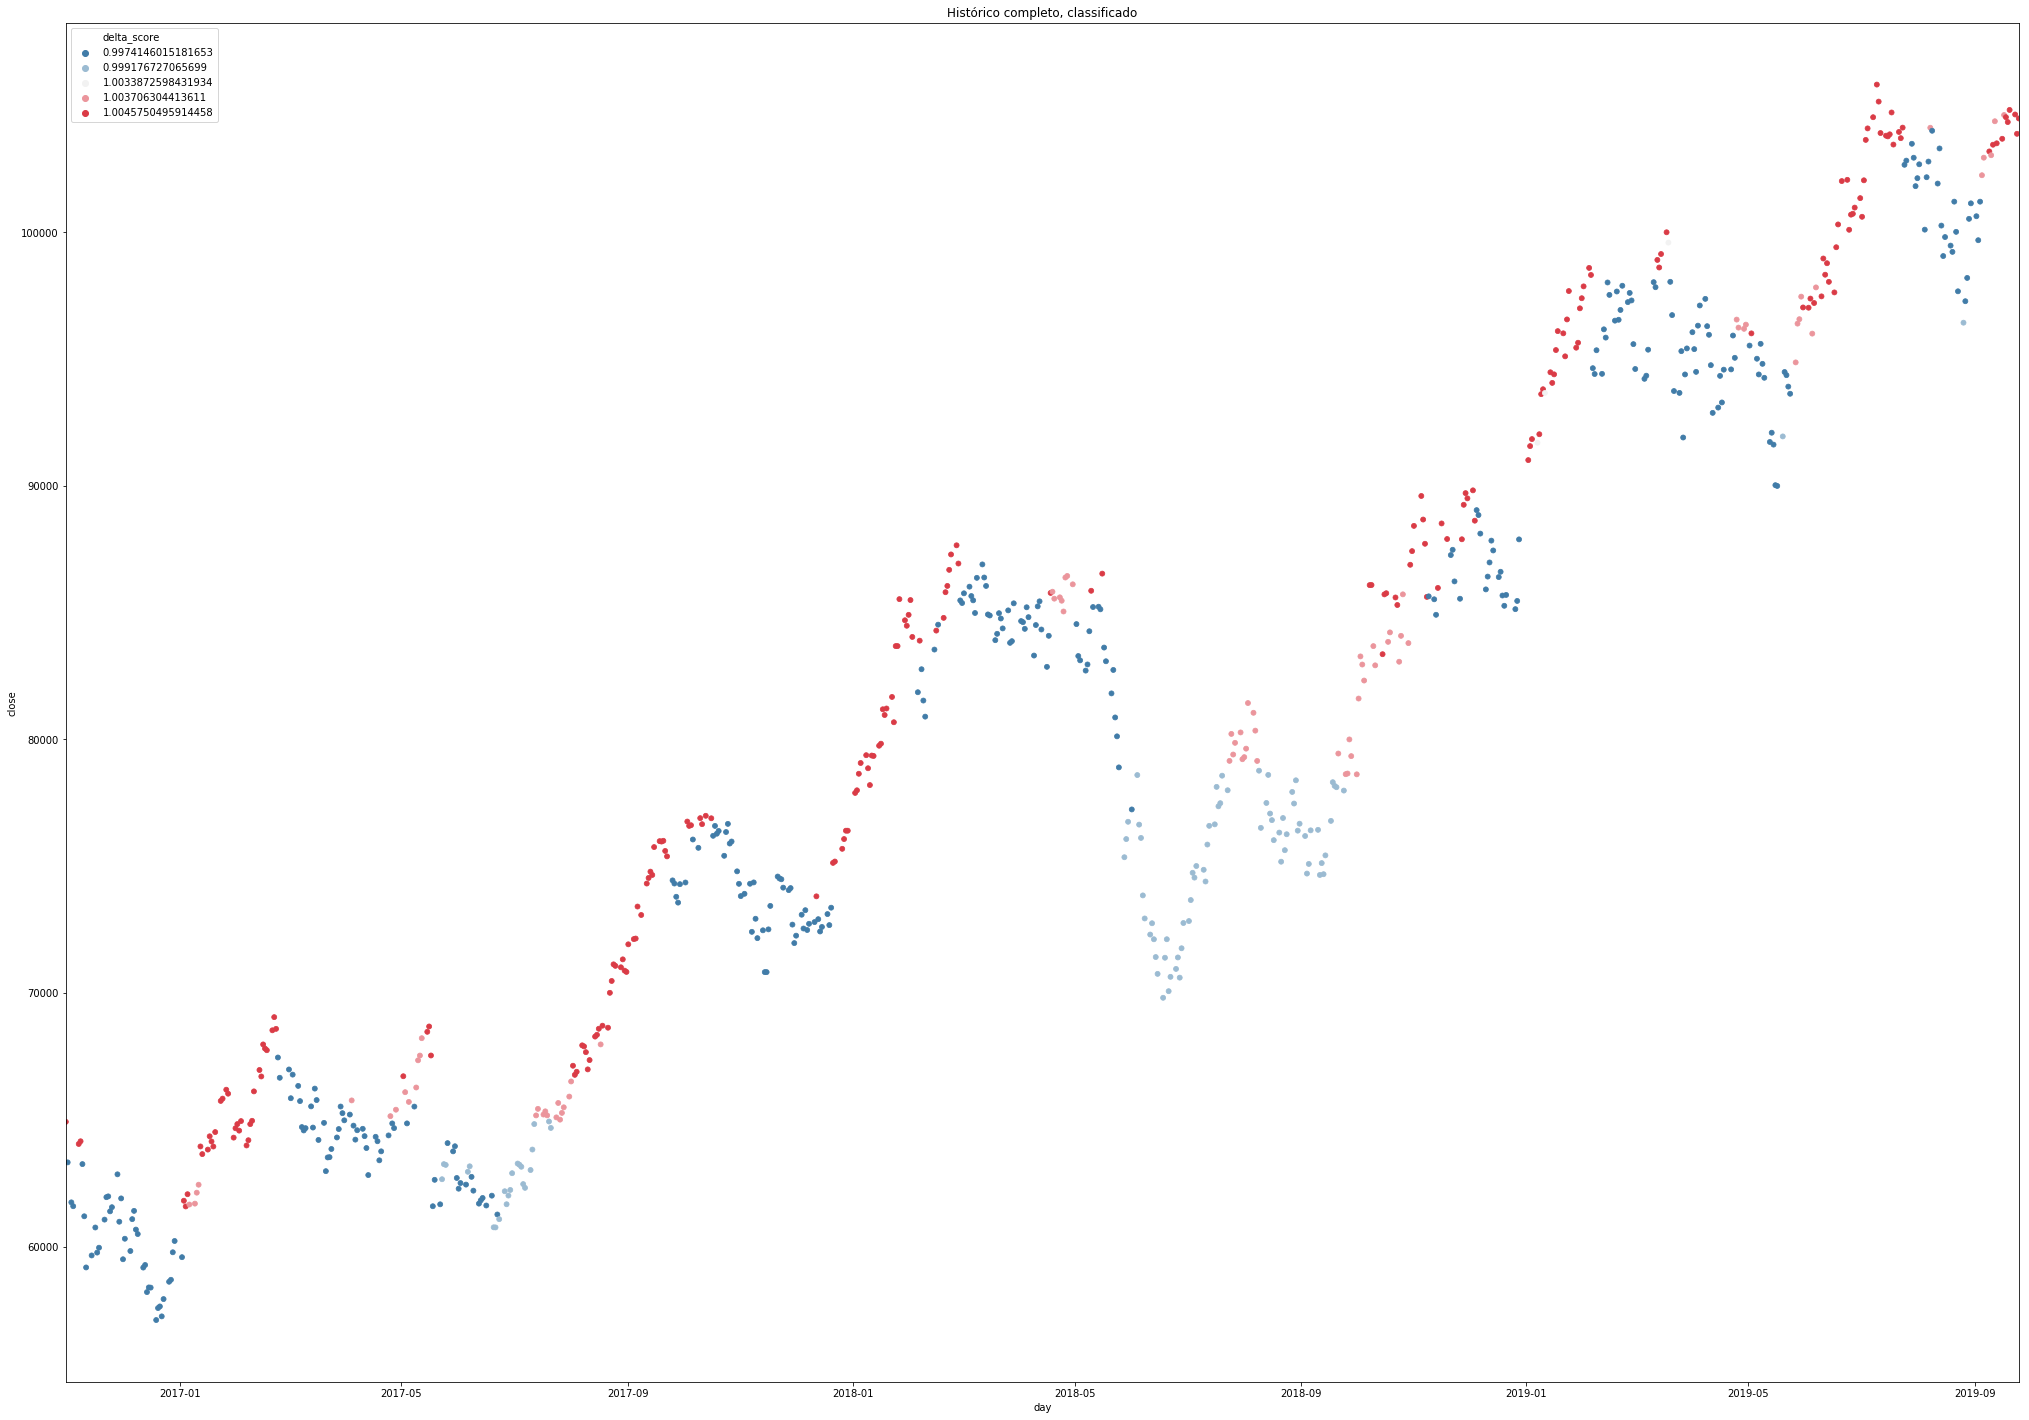

In [31]:
t = bvsp_labeled.iloc[-720:].reset_index()
palette = sns.diverging_palette(240, 10, n=t.delta_score.unique().size)
plt.figure(figsize=(35, 25))
ax = plt.subplot()
sns.scatterplot(x='day', y='close', data=t,
                hue='delta_score', palette=palette,
                s=25, markers=['o'], edgecolor=None, legend='full')

ax.set_xlim(t.day.min(), t.day.max())
plt.title('Histórico completo, classificado')
plt.savefig('plots/classified_720.png')


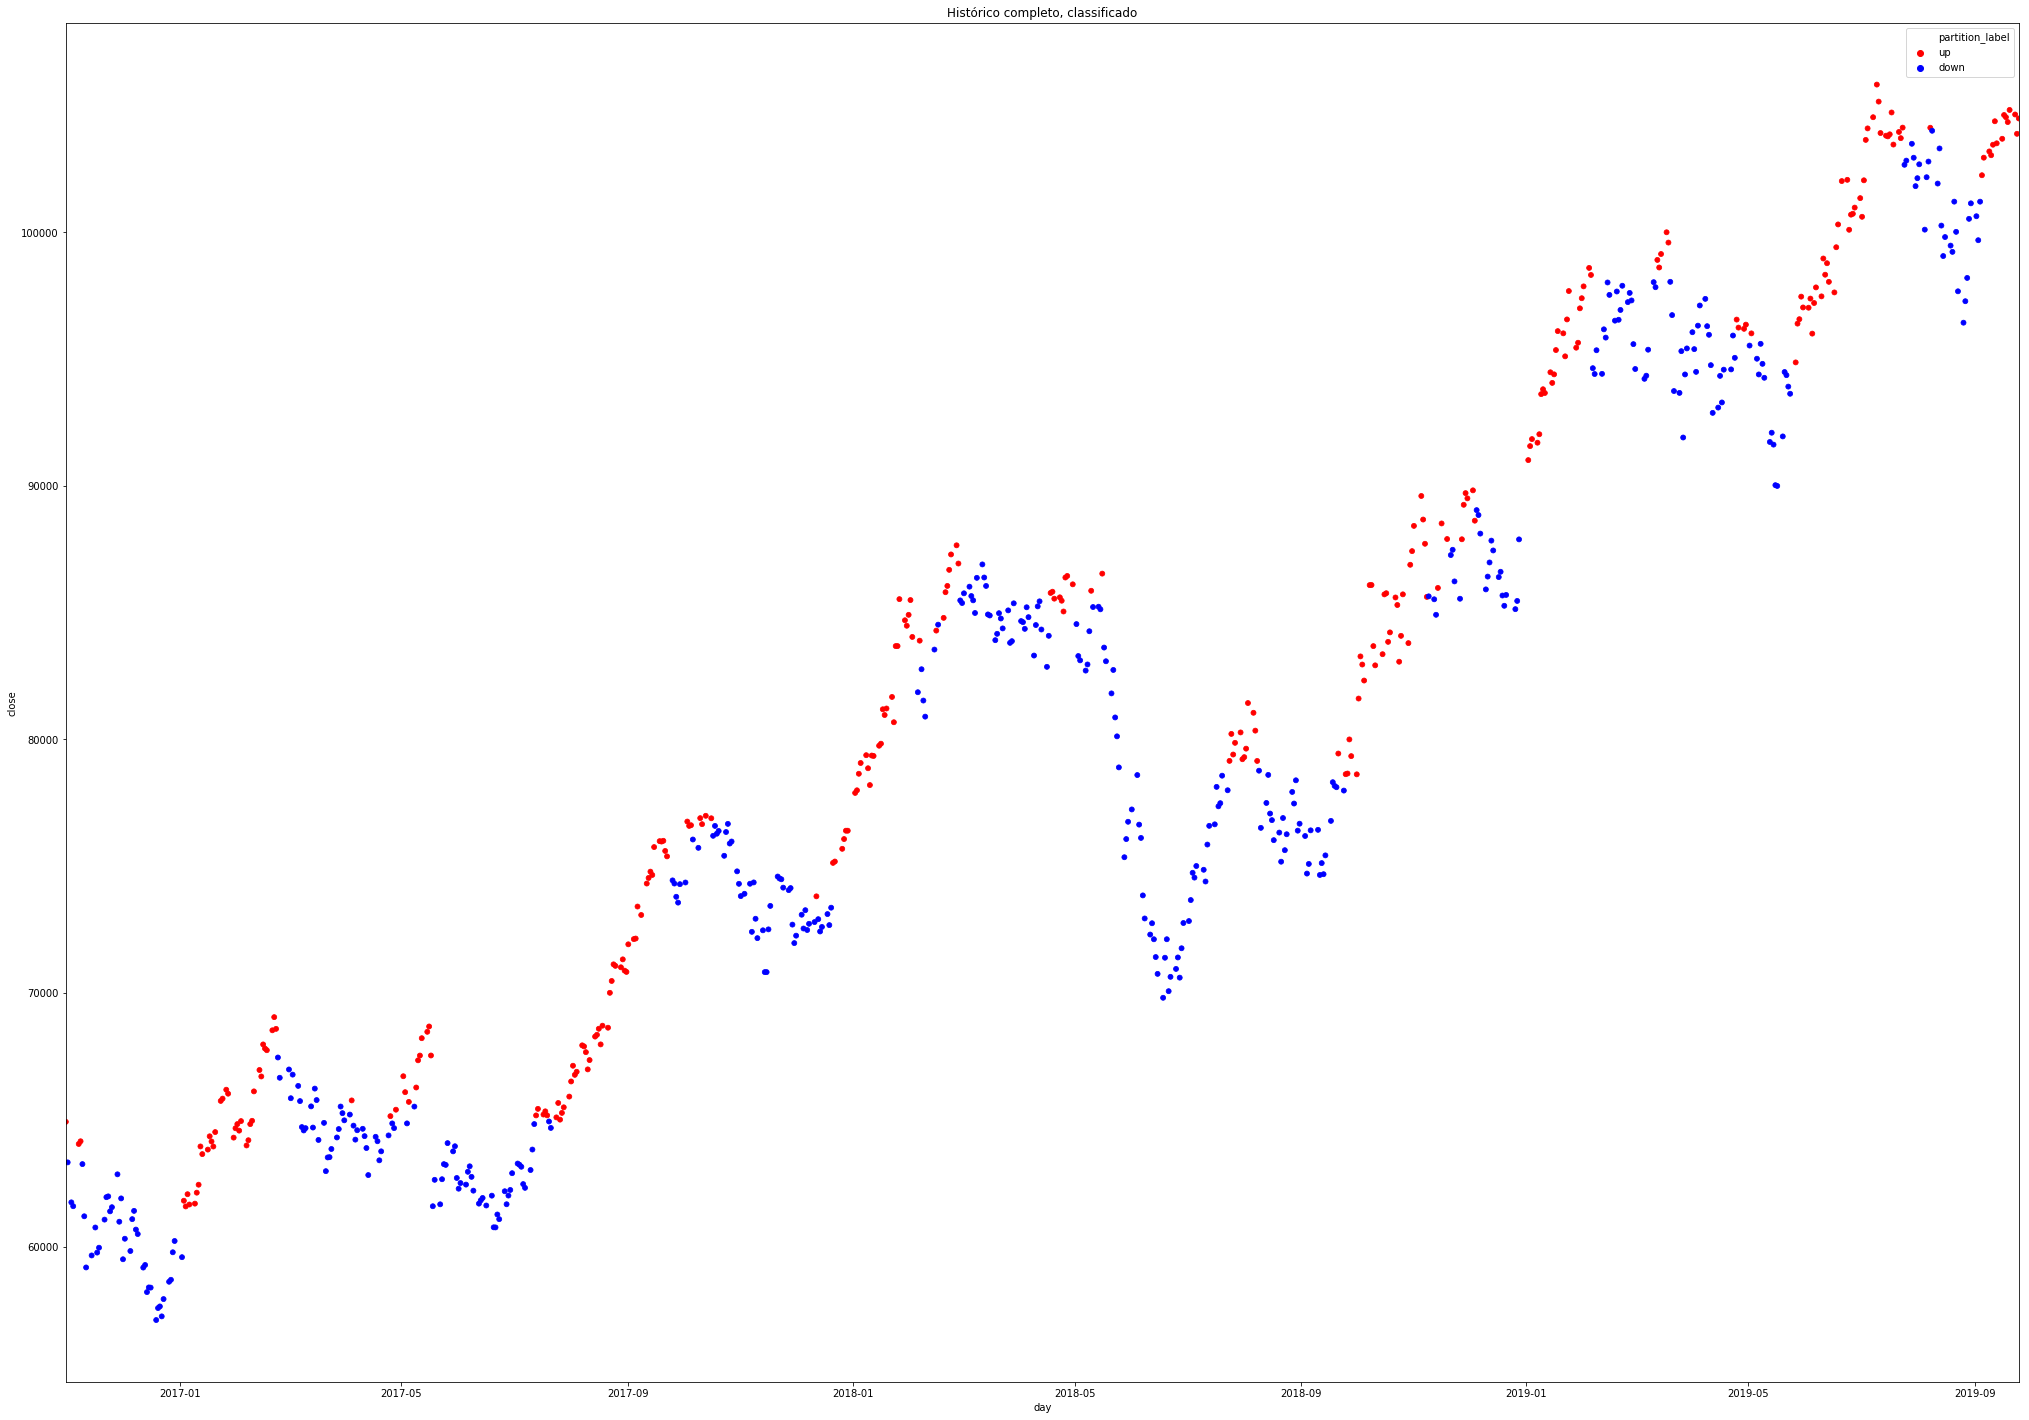

In [32]:
t = bvsp_labeled.iloc[-720:].reset_index()
palette={
    'up': 'red',
    'down': 'blue',
    'unknown': 'gray'
}
plt.figure(figsize=(35, 25))
ax = plt.subplot()
sns.scatterplot(x='day', y='close', data=t,
                hue='partition_label', palette=palette,
                s=25, markers=['o'], edgecolor=None, legend='full')

ax.set_xlim(t.day.min(), t.day.max())
plt.title('Histórico completo, classificado')
plt.savefig('plots/classified_720.png')


### Salvando dados

Salvando csv com...
  - Dias e seus fechamentos
  - Features de cada dia
  - Respectivos delta_score e partition_labels da respectiva partição

In [63]:
t = bvsp_labeled\
    .merge(df, left_index=True, right_index=True)\
    .sort_index()['close short_noise long_noise short_gradient long_gradient short_rel long_rel delta_score partition_label'.split()]
t.to_csv('bvsp_labeled.csv')
t

,close,short_noise,long_noise,short_gradient,long_gradient,short_rel,long_rel,delta_score,partition_label
day,,,,,,,,,
1994-11-09,4885.000000,0.016280,0.179333,-0.004960,0.006487,0.545812,0.842115,1.003387,up
1994-11-10,4992.600098,0.041635,0.197339,-0.002850,0.006656,0.788163,0.868706,1.003387,up
1994-11-11,4952.000000,0.035020,0.180099,-0.001793,0.006359,0.883575,0.858424,1.003387,up
1994-11-14,4948.700195,0.034596,0.171800,-0.000257,0.006411,0.878779,0.857588,1.003387,up
1994-11-16,4989.600098,0.042163,0.173864,0.000944,0.006492,0.938227,0.865013,1.003387,up
...,...,...,...,...,...,...,...,...,...
2019-09-19,104339.000000,0.030073,0.055465,0.002090,0.000859,0.966044,0.906598,1.004575,up
2019-09-20,104817.000000,0.032748,0.059344,0.001979,0.000903,1.000000,0.936805,1.004575,up
2019-09-23,104638.000000,0.028888,0.056738,0.002037,0.000754,0.978657,0.925493,1.004575,up


## Testes

In [51]:
q = pd.DataFrame({
    'close': bvsp_labeled.close,
    'delta_score': bvsp_labeled.close.rolling(2).apply(lambda x: (x[1] / x[0]))
})[1:]
q

/home/rainsong/miniconda3/envs/compsys/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
  This is separate from the ipykernel package so we can avoid doing imports until


,close,delta_score
day,,
1994-11-10,4992.600098,1.022027
1994-11-11,4952.000000,0.991868
1994-11-14,4948.700195,0.999334
1994-11-16,4989.600098,1.008265
1994-11-17,4873.700195,0.976772
...,...,...
2019-09-19,104339.000000,0.998154
2019-09-20,104817.000000,1.004581
2019-09-23,104638.000000,0.998292


(728242.0, 737327.0)

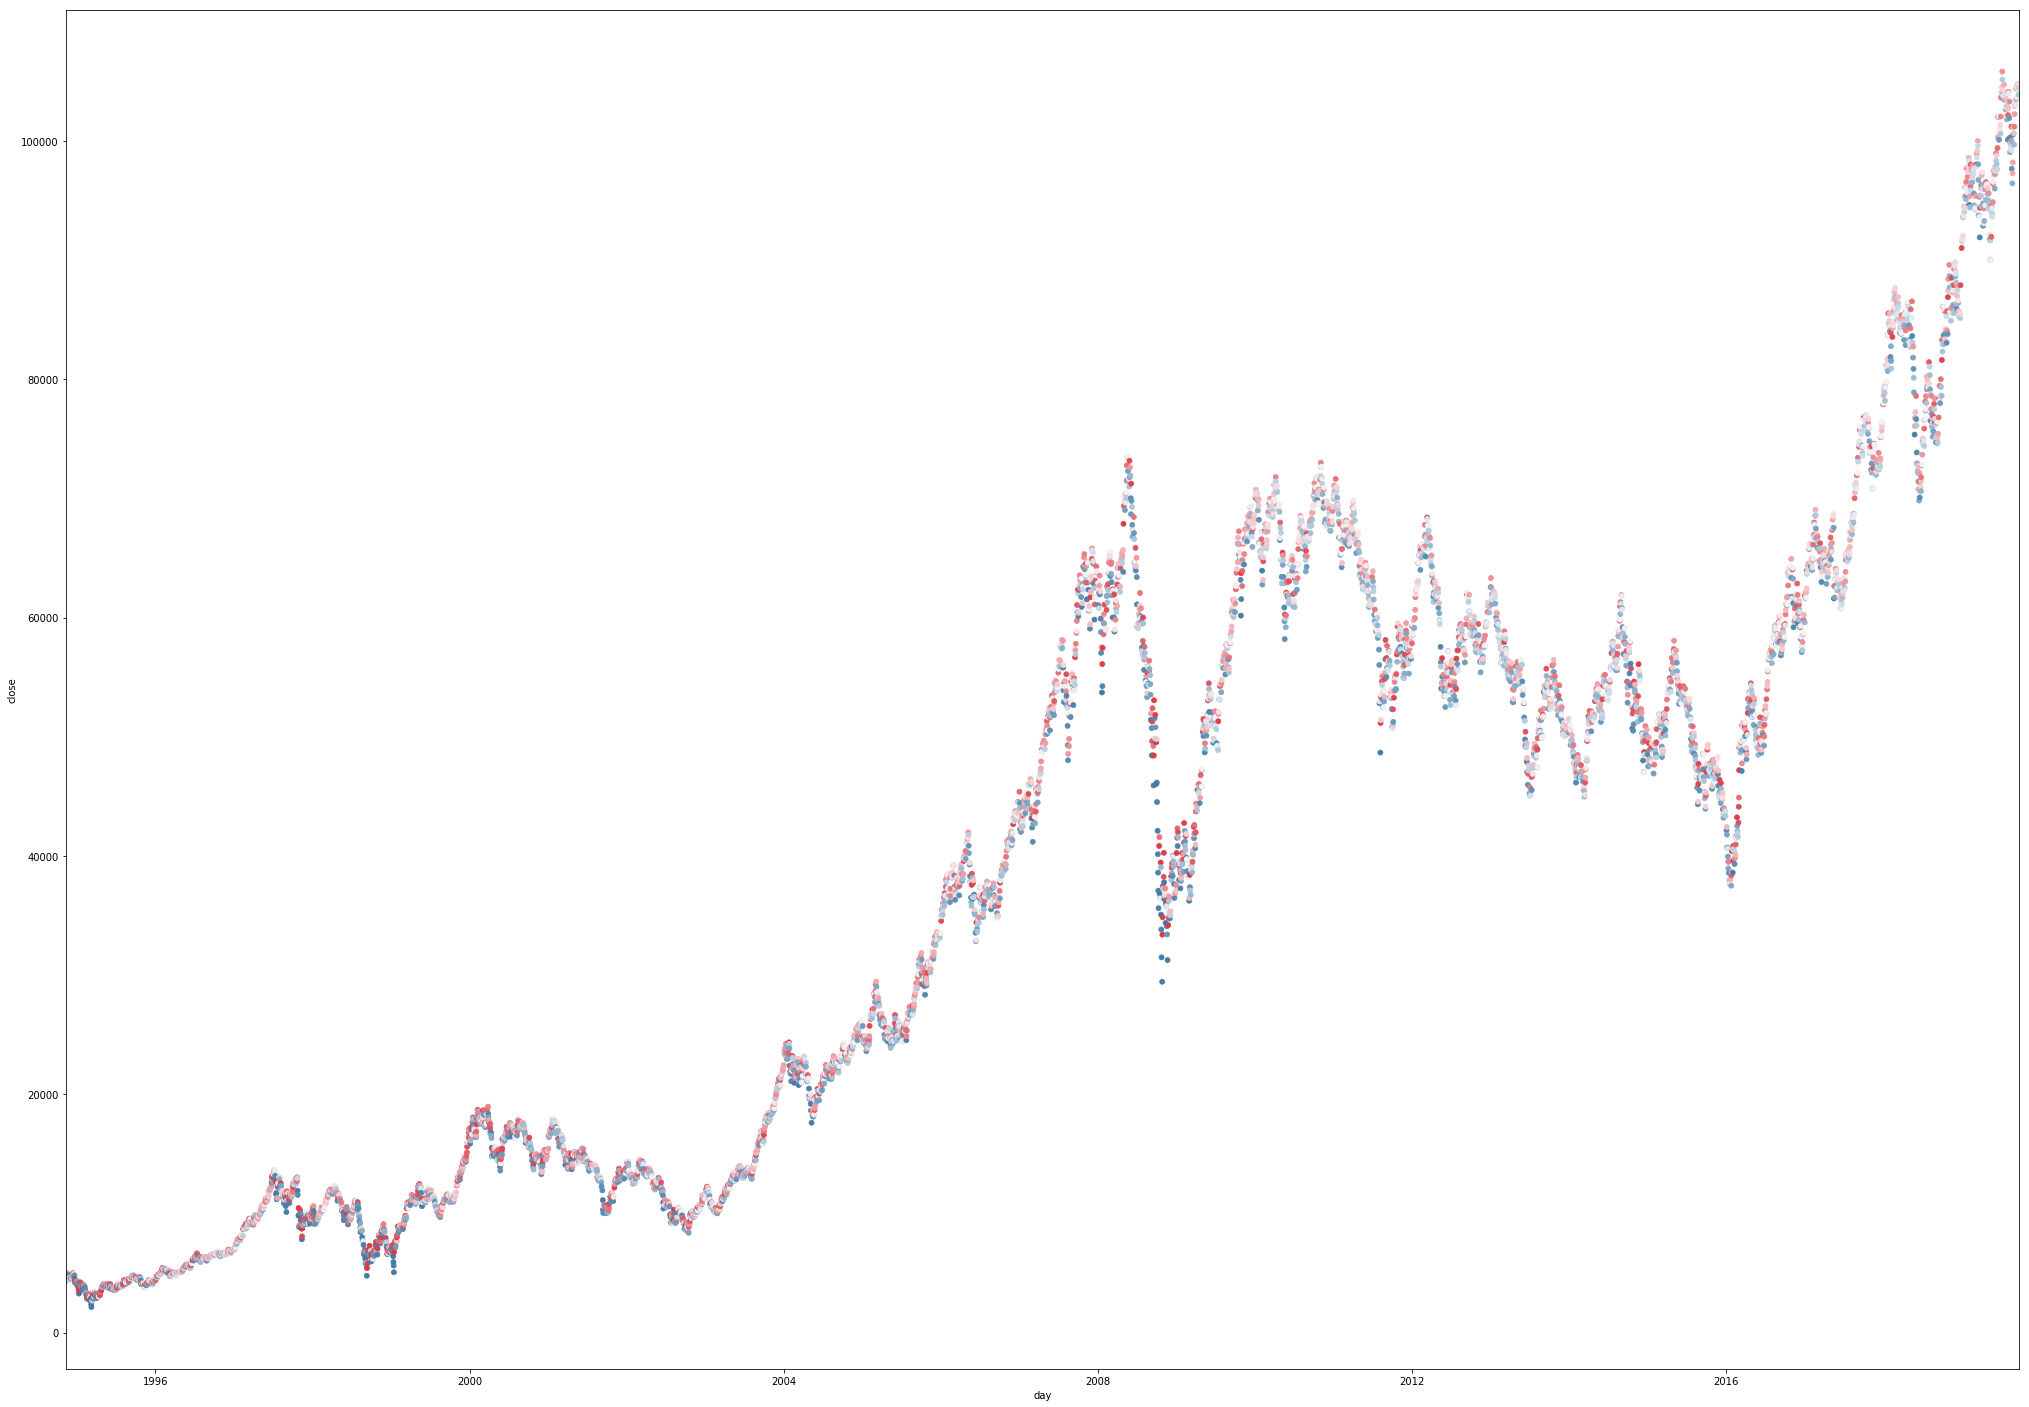

In [55]:
palette = sns.diverging_palette(240, 10, n=q.delta_score.unique().size)
t = q.reset_index()

plt.figure(figsize=(35, 25))
ax = plt.subplot()
sns.scatterplot(x='day', y='close', data=t,
                hue='delta_score', palette=palette,
                s=25, markers=['o'], edgecolor=None, legend=None)

ax.set_xlim(t.day.min(), t.day.max())
# plt.title('Histórico completo, classificado')
# plt.savefig('plots/classified_720.png')